# Calibration of the HBV model

In this chapter the parameters used in the HBV model are calibrated using the observation data. A set of parameters is used by the HBV model to model the discharge. These parameters are calibrated to make the model work for the catchment area of the Wien River. 

## Model Selection

To be able to model the expected future discharge, the Hydrologiska Byråns Vattenbalansavdelning (HBV) model is chosen. The developer of the model, Sten Bergström (1992), says the HBV model can best be classified as a semi-distributed conceptual model. The model represents a catchment area by using interconnected storage reservoirs to simulate the movement of water. By adjusting nine parameters, the HBV model can be calibrated to different catchment areas. The model requires 3 inputs, the forcings, which are precipitation, temperature and potential evapotranspiration.

The nine parameters that have to be calibrated are Imax, Ce, Sumax, Beta, Pmax, Tlag, Kf, Ks, and FM. The parameters represent the following:

*Table 1: The 9 parameters of the HBV model that need to be calibrated for the investigated catchment area. This table shows the meaning of the individual parameters. (Wawrzyniak et al., 2017; Seibert, 2000)*

| **Parameter** |       **Description**       |
|--------------:|:---------------------------:|
|      **Imax** |      Maximum intensity      |
|        **Ce** | Coefficient of evaporation  |
|     **Sumax** |       Field capacity        |
|      **Beta** |      Shape coefficient      |
|      **Pmax** |  Maximum percolation rate   |
|      **Tlag** |          Time lag           |
|        **Kf** |   Fast run-off parameter    |
|        **Ks** |   Slow run-off parameter    |
|        **FM** |      Degree-day factor      |


A visual representation of the HBV model can be seen in Figure 7.

![model_layout.png](figures/model_layout.png)

*Figure 7: Layout of the HBV Model (Hrachowitz, z.d.)* 
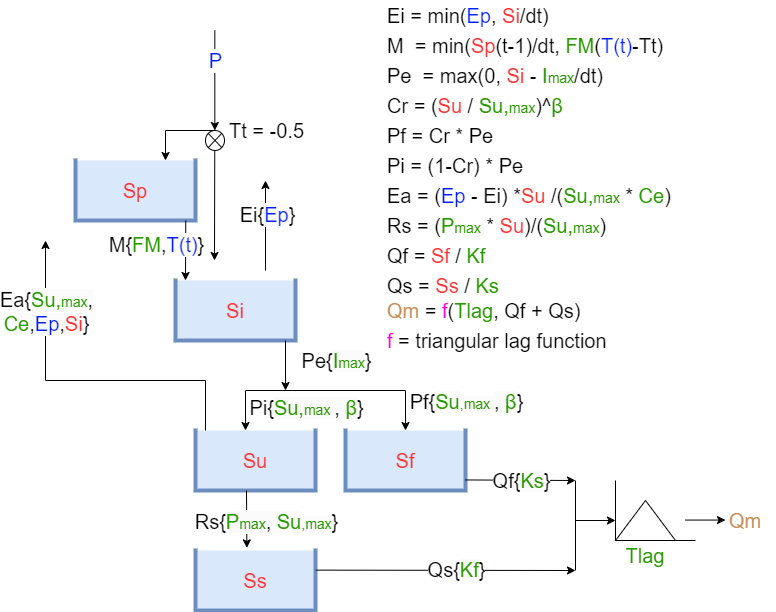

## Calibration

The model's performance with a certain parameter combination is assesed by evaluating how well it represents the distribution of discharges, since for my research the exact timing of certain discharges and peaks is not relevant. To measure the difference between the observed and modelled discharges, the Root Mean Squared Error (RMSE) is used. The Nelder-Mead Optimization is then applied to find the best set of parameters that results in the lowest RMSE. The model is trained on the first 75 percent of the observation data, and is then tested on the last 25 percent of the data. The test shows how well the model performs on data which it has never seen before. 

### Root Mean Squared Error

The RMSE is used to determine the difference between the observed and modelled discharge. First, the difference between the observed and modelled discharge is calculated for each day, called the error. The RMSE squares this error to give more weight to large differences, such as when observed peaks are not modelled well. This method causes peaks to contribute more heavily to the RMSE. After this, the mean of all squared values is taken, before the square root is applied to get the RMSE.

### Nelder-Mead Optimization 

The optimal parameter combination that results in the lowest RMSE is calculated using Nelder-Mead Optimization. The Nelder-Mead algorithm is a way to find the minimum of a function without needing to calculate its derivative. It does this by adjusting a group of points through steps like reflecting, expanding, squeezing, or shrinking until it gets closer to the best solution (Chen, 2023).

### Calibration Results

In [1]:
# First of all, some general python and eWaterCycle libraries need to be imported:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import minimize

#niceties
from rich import print
import seaborn as sns
sns.set()

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [2]:
# As stated in chapter 3, eWaterCycle provides access to the Caravan dataset, from which a Camel dataset of the catchment of the Wien River is loaded.
camelsgb_id = "lamah_208082"

In [3]:
# calibration dates on 75% of experiment dates

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2018-01-01T00:00:00Z"

calibration_start_time = experiment_start_date
calibration_end_time = "2007-08-31T00:00:00Z"

validation_start_time = "2007-09-01T00:00:00Z" 
validation_end_time = experiment_end_date

In [4]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# Path to forcing
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [5]:
# load data that you generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))
# print(camelsgb_forcing)

In [6]:
# Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). 
# For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below.
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])

In [7]:

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]

In [8]:
def objective_function_sorted_maximum(model_output, observation, calibration_start_time, calibration_end_time):
    calibration_start_time = pd.to_datetime(calibration_start_time)
    calibration_end_time = pd.to_datetime(calibration_end_time)

    model_output.index = model_output.index.tz_localize(None)  # Remove timezone
    observation.index = observation.index.tz_localize(None)
    calibration_start_time = calibration_start_time.tz_localize(None)
    calibration_end_time = calibration_end_time.tz_localize(None)

    model_output_filtered = model_output.loc[calibration_start_time:calibration_end_time]
    obs_filtered = observation.loc[calibration_start_time:calibration_end_time]

    # Sort data from high to low
    sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
    sorted_obs_data = np.sort(obs_filtered)[::-1]
    
    #calculate return periods
    m = len(sorted_model_data)
    rank = np.arange(1, m + 1)
    return_periods_days_model = (m + 1) / rank
    return_periods_years_model = return_periods_days_model / 365.25
    
    
    m = len(sorted_obs_data)
    rank = np.arange(1, m + 1)
    return_periods_days_obs = (m + 1) / rank
    return_periods_years_obs = return_periods_days_obs / 365.25

    sorted_model_data_subset = sorted_model_data
    sorted_obs_data_subset = sorted_obs_data

    
    if len(sorted_model_data_subset) != len(sorted_obs_data_subset):
        print(len(sorted_model_data_subset), len(sorted_obs_data_subset))
        raise ValueError("observation and data not equal length")

    objective_this_model = np.sqrt(np.mean((sorted_model_data_subset - sorted_obs_data_subset)**2))

    return objective_this_model

In [9]:
Q_pandas = ds_forcing["Q"].to_dataframe()

def optimization_function(parameter_vector):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)

    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))

    
    #calculate the objective function 
    discharge_series = pd.Series(data=Q_m, name="Modelled_discharge", index=time)
    objective_this_model = objective_function_sorted_maximum(discharge_series,Q_pandas,calibration_start_time + pd.Timedelta(days=1),calibration_end_time)
    del Q_m, time, discharge_series
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [12]:
# result.x
result = [7.70574780e-07, 1.32351315e+00, 1.00047603e+02, 3.89427105e+00,
       6.66366529e-01, 4.30576783e-02, 1.00508560e+00, 1.94023052e+00,
       4.58706486e-01]

The parameter combination that resulted in the best perfoming modelled discharge is as follows:

*Table 2: This table shows the values of the 9 parameters of the HBV model after calibration for the catchment area fo the Wien River*

| **Parameter** | **Value** |
|--------------:|:---------:|
|      **Imax** | $0.000  $ |
|        **Ce** | $1.324  $ |
|     **Sumax** | $100.048$ |
|      **Beta** | $3.894 $  |
|      **Pmax** | $0.666 $  |
|      **Tlag** | $0.043 $  |
|        **Kf** | $1.005 $  |
|        **Ks** | $1.940 $  |
|        **FM** |  $0.459$  |


In [14]:
par = result
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par, initial_storage=s_0)
model.initialize(config_file)


In [15]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [16]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

In [17]:
df = pd.DataFrame(model_output)

calibration_start_time = pd.to_datetime(calibration_start_time)
calibration_end_time = pd.to_datetime(calibration_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
calibration_start_time = calibration_start_time.tz_localize(None)
calibration_end_time = calibration_end_time.tz_localize(None)

model_output_filtered1 = model_output.loc[calibration_start_time:calibration_end_time]
ds_forcing_filtered1 = ds_forcing["Q"].loc[calibration_start_time:calibration_end_time]

The distributions of the observed and modelled discharges for the calibration period can be seen below in Figure 8.

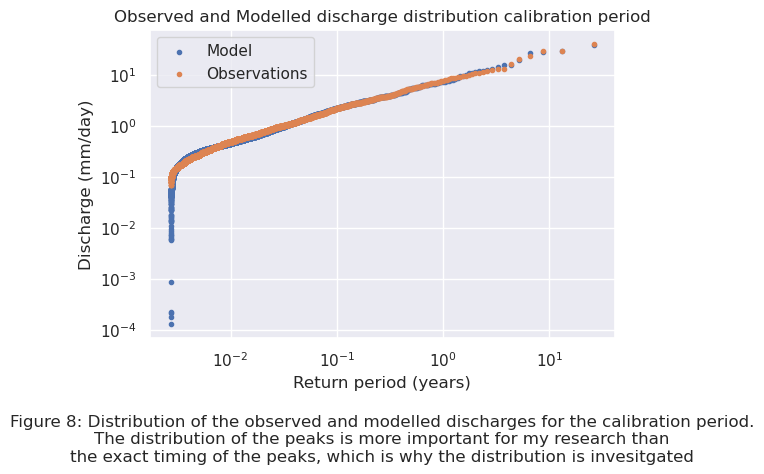

In [42]:
# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered1)[::-1]  # Sorteer aflopend
ds_forcing_filtered = np.sort(ds_forcing_filtered1)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365.25

m = len(ds_forcing_filtered)
rank = np.arange(1, m + 1)
return_periods_days_obs = (m + 1) / rank
return_periods_years_obs = return_periods_days_obs / 365.25

plt.figure(figsize=(6, 4))
plt.xscale('log')
plt.yscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, label='Model', marker='.')
plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations', marker='.')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (mm/day)')
plt.title('Observed and Modelled discharge distribution calibration period')
plt.text(0.5, -0.4, "Figure 8: Distribution of the observed and modelled discharges for the calibration period.\n"
         "The distribution of the peaks is more important for my research than\n" "the exact timing of the peaks, which is why the distribution is invesitgated", 
         ha="center", fontsize=12, transform=plt.gca().transAxes);

# plt.savefig("/home/thirza/BEPproject/book/EINDRAPPORT/calibration.png", dpi=300)

In [22]:
validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)

model_output_filtered2 = model_output.loc[validation_start_time:validation_end_time]
ds_forcing_filtered2 = ds_forcing["Q"].loc[validation_start_time:validation_end_time]

To test the ability of the model to predict discharges for periods of which it has never seen data before, the modelled discharge for the validation period is compared to the observed discharge. The distribution of discharges for modelled and observed data for the validation period can be seen in Figure 9.

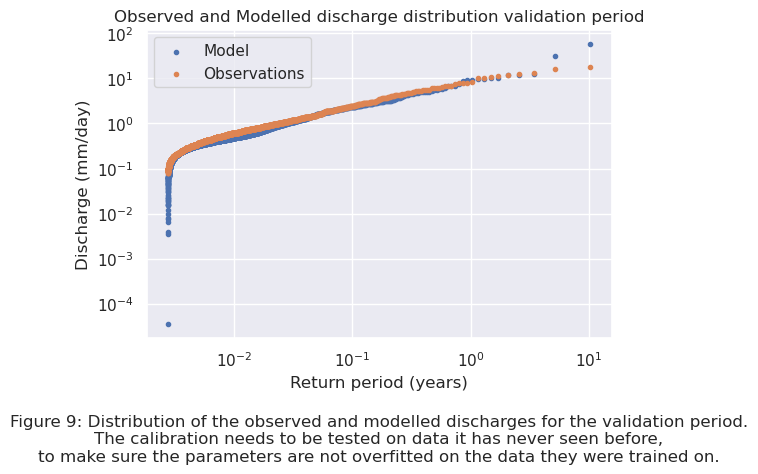

In [41]:
# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered2)[::-1]  # Sorteer aflopend
ds_forcing_filtered = np.sort(ds_forcing_filtered2)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365.25

m = len(ds_forcing_filtered)
rank = np.arange(1, m + 1)
return_periods_days_obs = (m + 1) / rank
return_periods_years_obs = return_periods_days_obs / 365.25
plt.figure(figsize=(6, 4))
plt.xscale('log')
plt.yscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, label='Model', marker='.')
plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations', marker='.')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (mm/day)')
plt.title('Observed and Modelled discharge distribution validation period')
plt.text(0.5, -0.4, "Figure 9: Distribution of the observed and modelled discharges for the validation period.\n"
         "The calibration needs to be tested on data it has never seen before,\n" "to make sure the parameters are not overfitted on the data they were trained on.", 
         ha="center", fontsize=12, transform=plt.gca().transAxes);

# plt.savefig("/home/thirza/BEPproject/book/EINDRAPPORT/validation.png", dpi=300)

The RMSE for both the calibration and validation period can be calculated and compared. The RMSE of the calibration period is $0.0632$, and is $0.7020$ for the validation period. The RMSE of the validation period is around 11 times larger than the one for the calibration period. The cause of the RMSE being larger for the validation period is visible in Figure 9 above. The model predicts more larger peaks than observed. This  is caused by the available observation data. The last period of the observation data contains no peaks, while the rest of the data does contain peaks. This causes the model to overestimate the actual amount of peaks present in the validation period. In both the calibration and validation period the model predicts lower discharges than are observed. A better insight in the differences between the modelled and observed discharges for the calibration and validation period can be found in Appendix I. Later in this chapter the return period of the threshold value is calculated by extrapolation of the modelled data. If the model works well enough with this parameter combination for the catchment area of the Wien River will be assessed in this part.

In [27]:
df['Modelled_discharge'].dropna(inplace=True)
Q_pandas["Q"].dropna(inplace=True)

validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

# validation_start_time = (validation_start_time + pd.Timedelta(days=1))

df.index = df.index.tz_localize(None)
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)

df_filtered = df[(df.index >= validation_start_time) & (df.index <= validation_end_time + pd.Timedelta(days=1))]
Q_filtered = Q_pandas[(Q_pandas.index >= validation_start_time) & (Q_pandas.index <= validation_end_time)]

# print(f'The objective for the validation period is {objective_function_sorted_maximum(df['Modelled_discharge'], Q_pandas["Q"], validation_start_time + pd.Timedelta(days=1), validation_end_time)}')

To be able to compare the model output to the observation data, the model output is converted from $mm/\text{day}$ to $m^3 / s$ as well. This is plotted below in Figure 10a for both the calibration and validation period. To check whether or not the modelled hydroghaph is realistic, the plot in Figure 10b zooms in on a period of two years. It can be seen that the model follows the discharge patterns quite well, which means the modelled discharge can be assessed as realistic.

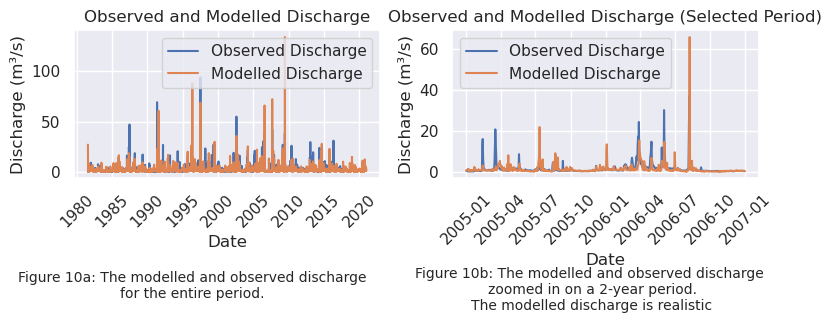

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

catchment_area = ds_forcing["area"].values

model_data = df['Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

discharge = []
for i in range(len(ds_forcing["Q"].values)):
    discharge.append((ds_forcing["Q"].values[i] * catchment_area * 1000) / (24 * 60 * 60))

x = ds_forcing["time"].values
y = discharge

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))  # 1 rij en 2 kolommen

# Plot voor de volledige periode
axs[0].plot(x, y, label='Observed Discharge')
axs[0].plot(df.index, model_data, label='Modelled Discharge')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Discharge (m³/s)')
axs[0].set_title('Observed and Modelled Discharge')
axs[0].legend()


start_date = "2005-01-01"
end_date = "2006-12-31"

time_series = pd.to_datetime(ds_forcing["time"].values)
mask = (time_series >= start_date) & (time_series <= end_date)

filtered_time = time_series[mask]
filtered_discharge = [discharge[i] for i in range(len(discharge)) if mask[i]]
filtered_model_data = df.loc[start_date:end_date, 'Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

axs[1].plot(filtered_time, filtered_discharge, label='Observed Discharge')
axs[1].plot(filtered_model_data.index, filtered_model_data, label='Modelled Discharge')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Discharge (m³/s)')
axs[1].set_title('Observed and Modelled Discharge (Selected Period)')
axs[1].legend()


fig.text(0.25, -0.02, "Figure 10a: The modelled and observed discharge\n" "for the entire period.", ha="center", fontsize=10)
fig.text(0.75, -0.06, "Figure 10b: The modelled and observed discharge \n" "zoomed in on a 2-year period.\n""The modelled discharge is realistic", ha="center", fontsize=10)

plt.tight_layout(rect=[0, 0.02, 1, 1])


plt.show()



Below, in Figure 11, the distribution of the modelled discharge is plotted. The blue line is fitted through the modelled data, and is extrapolated to be able to determine the return period for the threshold value. It can be seen that  a discharge of $530$ $m^3 / s$ has a return period of 398 years. In Chapter 3, the observed data resulted in a return period of 641 years for a discharge of $530$ $m^3 / s$. These two extrapolated return periods are not exactly the same. In Chapter 3, the influence of peaks in the data was considered as well. Removing the highest peaks resulted in a return period of 923 years. Removing peaks from the data increases the return period, and thus it can be assumed that adding peaks will decrease the return period. Removing the lowest discharges decreases the return period. The model overestimates the amount of peaks in the data, resulting in a smaller return period. Overestimating peaks is safer than underestimating peaks, because it prevents underdesigning of flood protection infrastructure and improves the preparedness for floodings. Since it can not be expected from the model to perfectly predict the discarges, a return period of 398 years for a discharge of $530$ $m^3 / s$ is considered close enough to the return period of 641 years for the observed data.

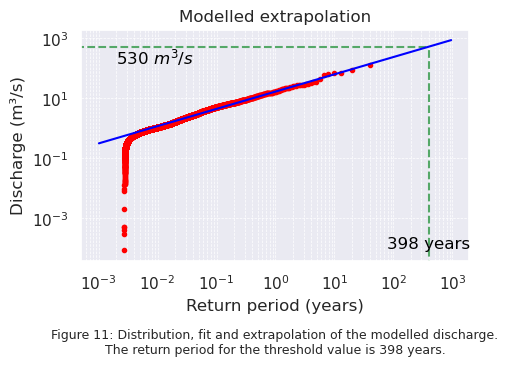

In [45]:
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
plt.figure(figsize=(5, 3))

# Sort data from high to low
sorted_model_data = np.sort(model_data)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365

def power_law(x, a, b):
    return a * x ** b
def calculate_return_periods(sorted_model_data):
    n = len(sorted_model_data)
    rank = np.arange(1, n + 1)
    return_periods_days = (n + 1) / rank
    return_periods_years = return_periods_days / 365.25
    
    # # Alleen de data voor returnperioden >= 0 behouden
    return_periods_years_subset = return_periods_years[return_periods_years >= 0]
    sorted_data_subset = sorted_model_data[return_periods_years >= 0]

    # Fit de power law functie
    params, _ = curve_fit(power_law, return_periods_years_subset, sorted_data_subset, maxfev=10000)
    a_opt, b_opt = params

    x_fit = np.logspace(np.log(min(sorted_model_data) + 0.05), np.log(max(return_periods_years_subset)/2), 1000)
    y_fit = power_law(x_fit, a_opt, b_opt)

    return x_fit, y_fit, a_opt, b_opt

x_fit, y_fit, a_opt, b_opt = calculate_return_periods(sorted_model_data)
def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)
y_target = 530
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

plt.hlines(y_target, xmin=0, xmax=x_value, colors='g', linestyles='dashed', label="y=530 Line")
plt.vlines(x_value, ymin=0, ymax=y_target, colors='g', linestyles='dashed', label="Intersection to x-axis")
plt.text(x_value, 0.0001, f'{x_value:.0f} years', ha='center', fontsize=12, color='black')
plt.text(0.002, y_target, f'{y_target:.0f} $m^3/s$', va='top', fontsize=12, color='black')

y_target = 534
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")
plt.xscale('log')
plt.yscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, color="red", label="Waarden", marker='.')
plt.plot(x_fit, y_fit, color='blue')
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (m³/s)')



plt.title('Modelled extrapolation')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.text(0.5, -0.4, "Figure 11: Distribution, fit and extrapolation of the modelled discharge.\n" "The return period for the threshold value is 398 years.", 
         ha="center", fontsize=9, transform=plt.gca().transAxes);

# plt.savefig("/home/thirza/BEPproject/book/EINDRAPPORT/scatterhbv2.png", dpi=300)

## Conclusion

It can be concluded that the best parameter combination for the catchment area of the Wien River is:

*Table 3: This table shows the values of the 9 parameters of the HBV model after calibration for the catchment area fo the Wien River*

| **Parameter** | **Value** |
|--------------:|:---------:|
|      **Imax** |  $0.000$  |
|        **Ce** |  $1.324$  |
|     **Sumax** | $100.048$ |
|      **Beta** |  $3.894$  |
|      **Pmax** |  $0.666$  |
|      **Tlag** |  $0.043$  |
|        **Kf** |  $1.005$  |
|        **Ks** |  $1.940$  |
|        **FM** |  $0.459$  |


In the next chapter, the HBV model will be run using forcings generated by CMIP6 in combination with these parameters.